In [123]:
from selenium import webdriver
import numpy as np
import glob
import os
import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
%matplotlib inline

### Scrapping website

In [2]:
d = webdriver.PhantomJS()
d.get("https://bitinfocharts.com/")

In [4]:
table = d.find_element_by_id('main_body').find_element_by_tag_name('tbody').get_attribute('innerHTML')
bs = BeautifulSoup(table, "lxml")
d.quit()

In [5]:
df = pd.DataFrame()
df['Columns'] = [k.find('td').getText() for k in bs.find_all('tr')]
for crypto in ['btc', 'eth', 'ltc']:
    df[crypto.upper()] = [p.getText() for p in bs.find_all(class_='c_%s' % crypto)]

### Cleaning dataframe

In [6]:
df2 = df.copy()
stopwords = ['BTC', 'ETH', 'LTC']
def remove_chars(x):
    num = re.sub('[^0-9]','', x)
    if len(str(num)) < 3:
        return x
    else:
        return num
    
def convert_number(x):
    return float(x.replace(',',''))

def remove_crypt(x):
    for k in stopwords:
        if k in x:
            return convert_number(x[:x.index(k)])
        
def clean_reward(x):
    for k in stopwords:
        if k in x:
            x = x[:x.index(k)]
            return tuple(map(float, x.replace(',','').split('+')))

df2.loc[0] = df2.loc[0].apply(lambda x:x[:x.index('(')] if '(' in x else x)
df2.loc[1] = df2.loc[1].apply(remove_chars)
df2.loc[2] = df2.loc[2].apply(lambda x:convert_number(x[x.find('$')+1:x.find('USD')]) if 'USD' in x else x)
df2.loc[3] = df2.loc[3].apply(lambda x:convert_number(x[x.find('$')+1:x.find('USD')]) if 'USD' in x else x)
df2.iloc[4, 1:] = df2.iloc[4, 1:].apply(convert_number)
for p in range(6,10):
    df2.iloc[p, 1:] = df2.iloc[p, 1:].apply(remove_crypt)
df2.iloc[14, 1:] = df2.iloc[14, 1:].apply(clean_reward)
df2.iloc[15, 1:] = df2.iloc[15, 1:].apply(clean_reward)

In [7]:
df2.head(20)

,Columns,BTC,ETH,LTC
0,,Bitcoin,Ethereum,Litecoin
1,Total,16677874,95845937,53914808
2,Price,8227.86,363.16,71.99
3,Market Capitalization,1.37223e+11,3.48073e+10,3.88108e+09
4,Transactions last 24h,300690,506225,27056
5,Transactions avg. per hour,"12,529","21,093","1,127"
6,Sent last 24h,4.98305e+06,1.54418e+07,1.80088e+07
7,Sent avg. per hour,207627,643408,750365
8,Avg. Transaction Value,16.57,30.5,665.61
9,Median Transaction Value,0.066,0.02,5.15


### BTC.com

In [8]:
# site : blockchain info / btc.com
# scrapper les N derniers blocks pour avoir les transactions fees 

In [85]:
year = '2017'
month = '11'
def scrap_one_day(year, month, day):
    d = webdriver.Chrome()
    d.get("https://btc.com/block?date=%s-%s-%s" % (year, month, day))
    table = d.find_element_by_class_name('table').find_element_by_tag_name('tbody').get_attribute('innerHTML')
    bs = BeautifulSoup(table, "lxml")
    d.quit()
    row = bs.find_all('tr')[1:]
    cols = pd.Series([k.getText() for k in bs.find_all('tr')[0].find_all('th')][:-1]), 
    values = pd.DataFrame([[k.getText().strip() for k in r.find_all('td')][:-1] for r in row])
    return cols, values

In [88]:
df = pd.DataFrame()
for dd in range(20, 10, -1):
    cols, temp = scrap_one_day(year, month, dd)
    df = pd.concat([df, temp])
df = df.reset_index(drop=True)
df.columns = cols[0]

In [116]:
for col in ['Tx Count', 'Stripped Size(B)', 'Size(B)', 'Weight', 'Avg Fee Per Tx']:
    df[col] = df[col].apply(lambda x:float(x.replace(',', '')))
df['RewardFee'] = df['Reward'].apply(lambda x:float(x[x.index('+ ')+2:x.index(' BTC')]))

In [105]:
df.RewardFee.mean(), df.RewardFee.std()

(3.4709752479650722, 2.2374125970988969)

In [121]:
# Remove block with only one transaction
df[df['Tx Count'] > 10]['Tx Count'].mean(), df[df['Tx Count'] > 10]['Tx Count'].std()

(2046.7646153846154, 558.25387618798743)

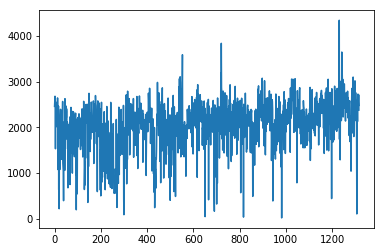

In [124]:
df[df['Tx Count'] > 10]['Tx Count'].plot()

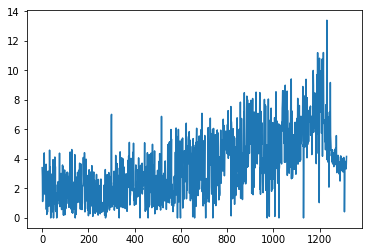

In [125]:
df.RewardFee.plot()